In [1]:
!pip install pandas numpy scikit-learn tensorflow matplotlib

Merged data shape: (599, 2069)
Epoch 1/50


C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0125 - loss: 0.7496 - val_accuracy: 0.0083 - val_loss: 0.7006
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0096 - loss: 0.7045 - val_accuracy: 0.0333 - val_loss: 0.6964
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0265 - loss: 0.6947 - val_accuracy: 0.0250 - val_loss: 0.6954
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0189 - loss: 0.6920 - val_accuracy: 0.0167 - val_loss: 0.6941
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0328 - loss: 0.6871 - val_accuracy: 0.0333 - val_loss: 0.6950
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0265 - loss: 0.6851 - val_accuracy: 0.0167 - val_loss: 0.6999
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0148 - loss: 0.6820 - val_accuracy: 0.0250 - val_loss: 0.6995
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0118 - loss: 0.6812 - val_accuracy: 0.0083 - val_loss: 0.6977
E

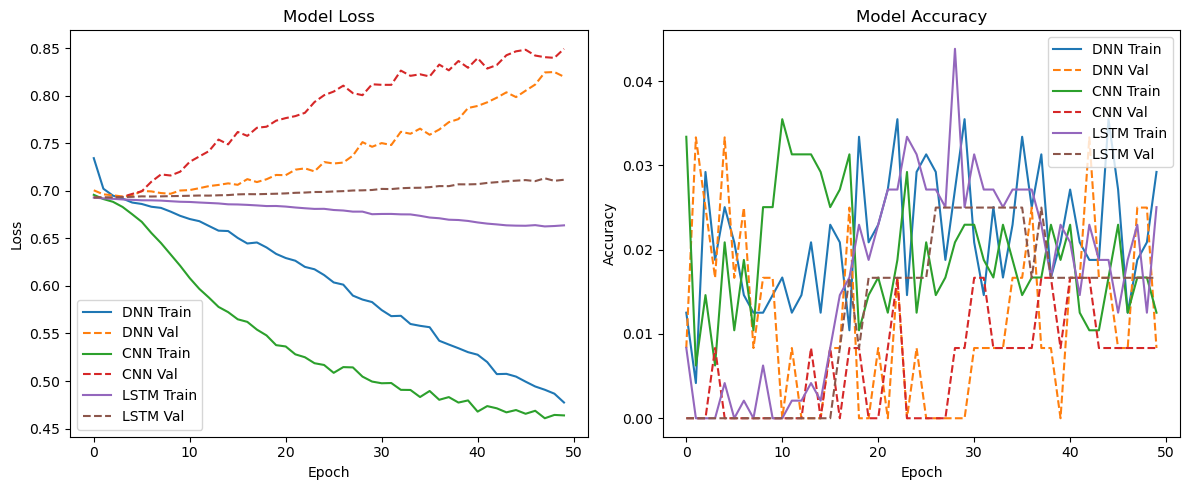

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, hamming_loss
import os

# Set random seed for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

# 1. Load and preprocess data
def load_and_preprocess_data(input_path, output_path):
    # Load CSVs
    input_df = pd.read_csv(input_path)
    output_df = pd.read_csv(output_path)
    
    # Merge on ID
    merged_df = pd.merge(input_df, output_df, on='ID', how='inner')
    print(f"Merged data shape: {merged_df.shape}")
    
    # Extract features (X) and labels (y)
    X = merged_df.iloc[:, 1:2005].values  # 2004 input columns
    y = merged_df.iloc[:, 2005:].values   # 64 output columns
    
    # Normalize input data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

# 2. Define models
def build_dnn(input_dim):
    model = Sequential([
        Dense(512, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dense(64, activation='sigmoid')  # 64 binary outputs
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_cnn(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        LSTM(32),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 3. Train and evaluate models
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name, epochs=50, batch_size=32):
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1)
    
    # Evaluate
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    hamming = hamming_loss(y_test, y_pred)
    
    print(f"\n{model_name} Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy (per output): {test_accuracy:.4f}")
    print(f"Hamming Loss: {hamming:.4f}")
    
    return history, test_loss, test_accuracy, hamming

# 4. Plot training history
def plot_history(histories, model_names):
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{name} Train')
        plt.plot(history.history['val_loss'], linestyle='--', label=f'{name} Val')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['accuracy'], label=f'{name} Train')
        plt.plot(history.history['val_accuracy'], linestyle='--', label=f'{name} Val')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 5. Main execution
def main():
    input_path = 'F:/Education/NSU/CSE/CSE499/Implementation/Dataset/8x8 Matrix Metasurface/parameter1.csv'
    output_path = 'F:/Education/NSU/CSE/CSE499/Implementation/Dataset/8x8 Matrix Metasurface/binary_matrices_ID.csv'
    
    # Load and preprocess data
    X_train, X_test, y_train, y_test = load_and_preprocess_data(input_path, output_path)
    
    # Reshape for CNN and LSTM
    X_train_cnn = X_train.reshape(X_train.shape[0], 1002, 2)  # (samples, 1002, 2)
    X_test_cnn = X_test.reshape(X_test.shape[0], 1002, 2)
    
    # Build and train models
    dnn_model = build_dnn(input_dim=2004)
    cnn_model = build_cnn(input_shape=(1002, 2))
    lstm_model = build_lstm(input_shape=(1002, 2))
    
    models = [dnn_model, cnn_model, lstm_model]
    model_names = ['DNN', 'CNN', 'LSTM']
    histories = []
    results = []
    
    for model, name in zip(models, model_names):
        X_train_input = X_train_cnn if name in ['CNN', 'LSTM'] else X_train
        X_test_input = X_test_cnn if name in ['CNN', 'LSTM'] else X_test
        history, test_loss, test_accuracy, hamming = train_and_evaluate_model(
            model, X_train_input, X_test_input, y_train, y_test, name
        )
        histories.append(history)
        results.append((name, test_loss, test_accuracy, hamming))
    
    # Compare results
    print("\nModel Comparison:")
    print("Model\tTest Loss\tTest Accuracy\tHamming Loss")
    for name, test_loss, test_accuracy, hamming in results:
        print(f"{name}\t{test_loss:.4f}\t{test_accuracy:.4f}\t{hamming:.4f}")
    
    # Plot training history
    plot_history(histories, model_names)

if __name__ == "__main__":
    main()

Input CSV rows: 599, Output CSV rows: 1500
Merged data shape: (599, 2069)
Train shape: (479, 2004), Test shape: (120, 2004)
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0422 - loss: 0.7539 - val_accuracy: 0.0083 - val_loss: 0.7004
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0263 - loss: 0.7033 - val_accuracy: 0.0083 - val_loss: 0.7001
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0067 - loss: 0.6966 - val_accuracy: 0.0083 - val_loss: 0.6978
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0091 - loss: 0.6891 - val_accuracy: 0.0417 - val_loss: 0.6940
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0201 - loss: 0.6889 - val_accuracy: 0.0000e+00 - val_loss: 0.6965
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0341 - loss: 0.6837 - val_accuracy: 0.0083 - val_loss: 0.6972
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0119 - loss: 0.6813 - val_accuracy: 0.0083 - val_lo

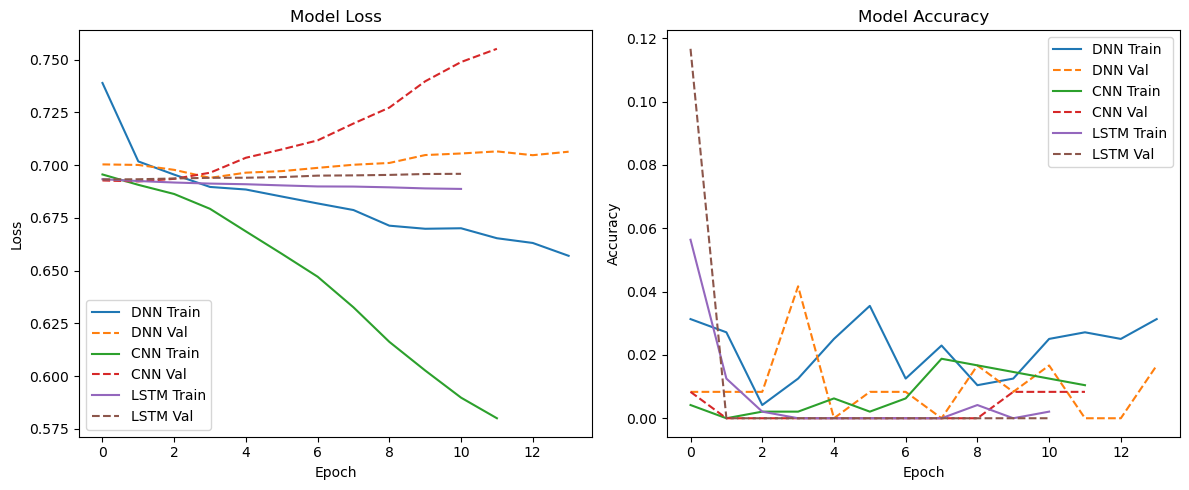

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, hamming_loss
import os

# Set random seed for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

# 1. Load and preprocess data
def load_and_preprocess_data(input_path, output_path):
    # Load CSVs
    input_df = pd.read_csv(input_path)
    output_df = pd.read_csv(output_path)
    
    # Verify row counts
    print(f"Input CSV rows: {len(input_df)}, Output CSV rows: {len(output_df)}")
    
    # Log IDs for debugging
    input_ids = set(input_df['ID'])
    output_ids = set(output_df['ID'])
    common_ids = input_ids.intersection(output_ids)
    missing_ids = input_ids - output_ids
    if missing_ids:
        print(f"Warning: {len(missing_ids)} IDs in input file not found in output file: {sorted(missing_ids)}")
    
    # Merge on ID
    merged_df = pd.merge(input_df, output_df, on='ID', how='inner')
    print(f"Merged data shape: {merged_df.shape}")
    
    # Extract features (X) and labels (y)
    X = merged_df.iloc[:, 1:2005].values  # 2004 input columns
    y = merged_df.iloc[:, 2005:].values   # 64 output columns
    
    # Verify output is binary
    if not np.all(np.isin(y, [0, 1])):
        print("Warning: Output labels contain non-binary values")
    
    # Normalize input data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test, merged_df['ID'].values

# 2. Define models
def build_dnn(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dense(64, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_cnn(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Conv1D(32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_lstm(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 3. Train and evaluate models
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name, epochs=50, batch_size=32):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                       epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=1)
    
    # Evaluate
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    hamming = hamming_loss(y_test, y_pred)
    
    print(f"\n{model_name} Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy (per output): {test_accuracy:.4f}")
    print(f"Hamming Loss: {hamming:.4f}")
    
    # Sample predictions
    print(f"Sample predictions for {model_name} (first 5 test samples, first 10 outputs):")
    for i in range(min(5, len(y_test))):
        print(f"Sample {i+1}: True={y_test[i][:10]}, Pred={y_pred[i][:10]}")
    
    return history, test_loss, test_accuracy, hamming

# 4. Plot training history
def plot_history(histories, model_names):
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{name} Train')
        plt.plot(history.history['val_loss'], linestyle='--', label=f'{name} Val')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['accuracy'], label=f'{name} Train')
        plt.plot(history.history['val_accuracy'], linestyle='--', label=f'{name} Val')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    output_dir = os.path.dirname('F:/Education/NSU/CSE/CSE499/Implementation/Dataset/8x8 Matrix Metasurface/')
    plt.savefig(os.path.join(output_dir, 'model_performance.png'))
    plt.show()

# 5. Main execution
def main():
    input_path = 'F:/Education/NSU/CSE/CSE499/Implementation/Dataset/8x8 Matrix Metasurface/parameter1.csv'
    output_path = 'F:/Education/NSU/CSE/CSE499/Implementation/Dataset/8x8 Matrix Metasurface/binary_matrices_ID.csv'
    
    # Verify file existence
    if not os.path.exists(input_path) or not os.path.exists(output_path):
        raise FileNotFoundError("Input or output CSV file not found")
    
    # Load and preprocess data
    X_train, X_test, y_train, y_test, ids = load_and_preprocess_data(input_path, output_path)
    
    # Reshape for CNN and LSTM
    X_train_cnn = X_train.reshape(X_train.shape[0], 1002, 2)  # (samples, 1002, 2)
    X_test_cnn = X_test.reshape(X_test.shape[0], 1002, 2)
    
    # Build and train models
    dnn_model = build_dnn(input_dim=2004)
    cnn_model = build_cnn(input_shape=(1002, 2))
    lstm_model = build_lstm(input_shape=(1002, 2))
    
    models = [dnn_model, cnn_model, lstm_model]
    model_names = ['DNN', 'CNN', 'LSTM']
    histories = []
    results = []
    
    for model, name in zip(models, model_names):
        X_train_input = X_train_cnn if name in ['CNN', 'LSTM'] else X_train
        X_test_input = X_test_cnn if name in ['CNN', 'LSTM'] else X_test
        history, test_loss, test_accuracy, hamming = train_and_evaluate_model(
            model, X_train_input, X_test_input, y_train, y_test, name
        )
        histories.append(history)
        results.append((name, test_loss, test_accuracy, hamming))
    
    # Compare results
    print("\nModel Comparison:")
    print("Model\tTest Loss\tTest Accuracy\tHamming Loss")
    for name, test_loss, test_accuracy, hamming in results:
        print(f"{name}\t{test_loss:.4f}\t{test_accuracy:.4f}\t{hamming:.4f}")
    
    # Plot training history
    plot_history(histories, model_names)

if __name__ == "__main__":
    main()